# Exponential weighted moving average

**TL;DR** This notebook demonstrates the performance improvement of using a numba JIT compiled algorithm for calculating exponential weighted moving average over the Pandas equivalent for some sample data.

In [1]:
import numpy as np
import pandas as pd
from numba import jit
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 16, 8

In [2]:
@jit(nopython=True)
def ewma(data, alpha, adjust, ignore_na):
    # More or less a straight port of the corresponding pandas class
    
    old_wt_factor = 1. - alpha
    new_wt = 1. if adjust else alpha
    
    n = data.shape[0]
    output = np.empty(n)  

    weighted_avg = data[0]
    is_observation = (weighted_avg == weighted_avg)
    nobs = int(is_observation)
    output[0] = weighted_avg if (nobs >= 1) else np.nan
    old_wt = 1.
    
    for i in range(1, n):
        cur = data[i]
        is_observation = (cur == cur)
        nobs += int(is_observation)
        if weighted_avg == weighted_avg:

            if is_observation or (not ignore_na):

                old_wt *= old_wt_factor
                if is_observation:

                    if weighted_avg != cur:
                        weighted_avg = ((old_wt * weighted_avg) +
                                        (new_wt * cur)) / (old_wt + new_wt)
                    if adjust:
                        old_wt += new_wt
                    else:
                        old_wt = 1.
        elif is_observation:
            weighted_avg = cur

        output[i] = weighted_avg if (nobs >= 1) else np.nan

    return output

In [3]:
# create some sample data and introduce a few NaNs
data = np.arange(1e5) * 1.0
data[3] = np.nan
data[4] = np.nan

In [4]:
expected = pd.Series(data).ewm(alpha=0.1, adjust=True, ignore_na=False).mean().values

In [5]:
output = ewma(data, alpha=0.1, adjust=True, ignore_na=False)

In [6]:
np.allclose(expected, output)  # assert output is as per Pandas equivalent

True

In [7]:
def benchmarks():
    
    res = []
    
    for exponent in range(3, 7):
        n = 10**exponent
        data = np.arange(n).astype(float)
        data[3] = np.nan
        data[4] = np.nan
        data[-1] = np.nan
        s = pd.Series(data)

        t1 = time.time()
        pandas_output = s.ewm(alpha=0.1, adjust=True, ignore_na=False).mean().values
        t2 = time.time()
        res.append(('pandas', n, (t2 - t1)))
    
        t1 = time.time()
        ewma_output = ewma(data, alpha=0.1, adjust=True, ignore_na=False)
        t2 = time.time()
        res.append(('ewma', n, (t2 - t1))) 
        
        assert np.allclose(pandas_output, ewma_output)
        
    return res

In [8]:
data = benchmarks()
df = pd.DataFrame(data, columns = ['fn', 'population', 'time (ms)'])

df['time (ms)'] = df['time (ms)'].apply(lambda x: x * 1000.) 
df = pd.pivot_table(df, values='time (ms)', index=['population'], columns=['fn'], aggfunc=np.sum)
df

fn,ewma,pandas
population,,
1000,0.000000,1.012325
10000,0.000000,1.934528
100000,0.981808,9.813309
1000000,8.857965,105.378151


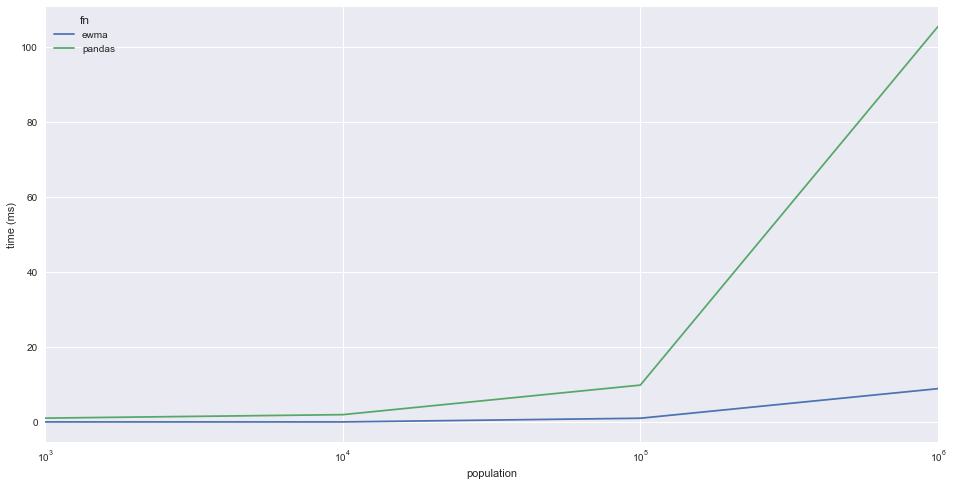

In [9]:
df.plot(logx=True)
plt.ylabel('time (ms)')